To calibrate pod for work:
1. Launcher -> Terminal
2. Create virtual environment: 
    python -m venv venv --system-site-packages
3. Then activate virtual environment: 
    * cd venv
    * source bin/activate
    * pip install --upgrade pip 
    * python -m ipykernel install --user --name=venv (name=huggingface) 
4. Create new notebook (python 3) with launcher '+' (beside terminal tab)
    * Select the name of your virtual environment
5. Install source requirements into venv:
    pip freeze > requirements.txt
    mv requirements.txt venv
    pip install -r requirements.txt
6. install packages in terminal: (update list as needed)
    * pip install datasets transformers scikit-learn matplotlib seaborn

~ 15 minutes total time to install
pip freeze > requirements.txt
mv requirements.txt venv
pip install -r requirements.txt
pip install datasets transformers

___
To Transfer Files from RunPod:
1. Run the following in bash:
   runpodctl send transfer_test.csv (have virtual_env as your cd)
2. Then, locally run:
   runpodctl receive (code)
3. If this fails, Try alternatives (Have prompt for Claude prepared)
   https://docs.runpod.io/pods/storage/transfer-files

Setup

In [ ]:
import torch
from datasets import load_dataset
from transformers import pipeline, AutoConfig, AutoModel
import ipywidgets as widgets
from IPython.display import display
import time
import math
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import math 
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

%config InteractiveShell.ast_node_interactivity = 'all'
%config DisplayFormatter.float_precision = 10

c:\Users\WulfN\Python Projects\venv\Lib\site-packages\IPython\core\interactiveshell.py:3517: UserWarning: Config option `float_precision` not recognized by `DisplayFormatter`.
  if await self.run_code(code, result, async_=asy):


Functions for Results Analysis

In [11]:

def results_table(results_list):
    """
    Input: 
        List of results inferred from huggingface model(s)

    Output: 
        Results simplified to Pandas Table per model
    """
    
    res_tables = {}    
    
    # Change Format of Results to Pandas DataFrame
    for i in range(len(results)):
        # Results for model i in model results list
        m_result = list(results.items())[i][1]
        
        # Reformat to Pandas DataFrame for model result i 
        res = pd.DataFrame()
        for j in range(len(m_result)):
            join = pd.DataFrame({'label': [m_result[j][1]['label']], 'score': [round(m_result[j][1]['score'], 5)]})
            res = pd.concat([res, join])
    
        # Simplify to only give 'real' probabilities 
        res = res.reset_index(drop=True)
        res['y_hat'] = np.where(res.label == 'Fake', 1 - res.score, res.score)
        res['label'] = np.where(res.label == 'Fake', 'Real', res.label)

        # Add true labels and error terms
        res['y_true'] = image_dt['train'][0:num_test]['label']
        res['error'] = abs(res['y_true'] - res['y_hat']).round(6)
        
        # Save results of model i to results table
        res_df = f'model_{i+1}_res'
        res_tables[res_df] = res

    return res_tables

def res_graphs(res):
    """
    Input: 
        List of results as a pandas dataframe
        
    Output: 
        ROC curve and confusions matricies per model
    """
    # Get optimal threshold
    fpr, tpr, threshold = metrics.roc_curve(res['y_true'], res['y_hat'])

    transform_threshold = [0] * len(threshold)
    for i in range(len(threshold)):
        transform = ([1]-fpr[i])**2 + tpr[i]**2
        transform_threshold[i] = math.sqrt(transform);  

    transform_threshold = np.array(transform_threshold);  
    max_thresh = threshold[transform_threshold.argmax(axis=0)]

    # Apply optimal threshold
    res['y_pred'] = np.where(res['y_hat'] > max_thresh, 1, 0)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Roc plot
    roc_auc = metrics.auc(fpr, tpr)
    roc_auc_plot = (sns.lineplot(x=fpr, y=tpr, errorbar=None, ax=ax1, 
                                estimator=None, label='AUC='+str(round(roc_auc, 5)))
                       .set(title='ROC curve', ylabel='True Positive Rate', xlabel='False Positive Rate'));  

    # Confusion Matricies
    cm = confusion_matrix(res['y_true'], res['y_pred']);  
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g', ax=ax2).set(title='Classification Quantities'); 

    cm2 = np.round(confusion_matrix(res['y_true'], res['y_pred'])/(len(res['y_pred'])/100), 2)
    sns.heatmap(cm2, annot=True, cmap='Greens', fmt='g', ax=ax3).set(title='Classification Percents'); 

    # Consider Error Plot


Preview images from the different datasets. 

Each have similar image input dimensions
 - image_dt_1
 - image_dt_2
 - image_dt_3
 - image_dt_4

Dataset Load and Preview

In [25]:
image_dt_1 = load_dataset("Whab/deepfake").shuffle(seed=12); 
image_dt_2 = load_dataset("JamieWithofs/Deepfake-and-real-images-2").shuffle(seed=12);  # Uncertain why a train/test/validation split is made
image_dt_3 = load_dataset("Hemg/deepfake-and-real-images").shuffle(seed=12);  
image_dt_4 = load_dataset("OpenRL/DeepFakeFace").shuffle(seed=12);  

In [35]:
print('Dataset Image Dimensions:',image_dt_1['train'][0]['image'].size, '\n', '       Number of Images:', image_dt_1.num_rows, '\n', '       Features:', image_dt_1['train'].features)
print('Dataset Image Dimensions:',image_dt_2['train'][0]['image'].size, '\n', '       Number of Images:', image_dt_2.num_rows, '\n', '       Features:', image_dt_2['train'].features)
print('Dataset Image Dimensions:',image_dt_3['train'][0]['image'].size, '\n', '       Number of Images:', image_dt_3.num_rows, '\n', '       Features:', image_dt_3['train'].features)
print('Dataset Image Dimensions:',image_dt_4['train'][0]['image'].size, '\n', '       Number of Images:', image_dt_4.num_rows, '\n', '       Features:', image_dt_4['train'].features)

Dataset Image Dimensions: (256, 256) 
        Number of Images: {'train': 179430} 
        Features: {'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['Fake', 'Real'], id=None)}
Dataset Image Dimensions: (286, 256) 
        Number of Images: {'train': 3264, 'test': 1069, 'validation': 1072} 
        Features: {'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['Fake', 'Real'], id=None)}
Dataset Image Dimensions: (256, 256) 
        Number of Images: {'train': 190335} 
        Features: {'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['Fake', 'Real'], id=None)}
Dataset Image Dimensions: (512, 512) 
        Number of Images: {'train': 120004} 
        Features: {'image': Image(mode=None, decode=True, id=None)}


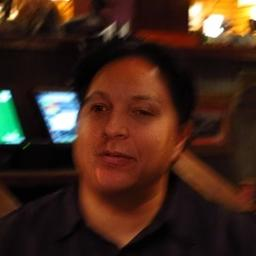

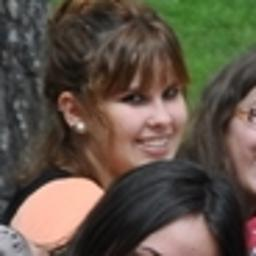

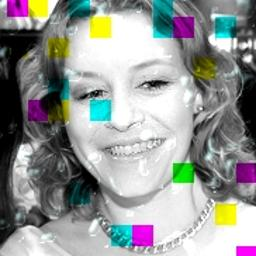

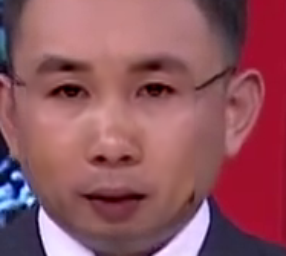

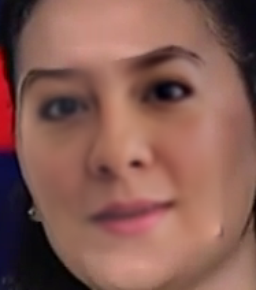

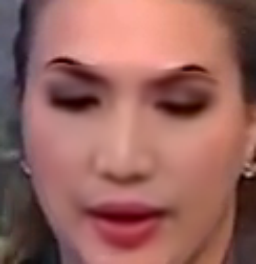

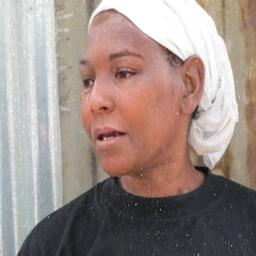

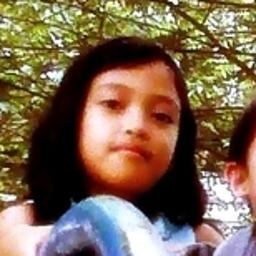

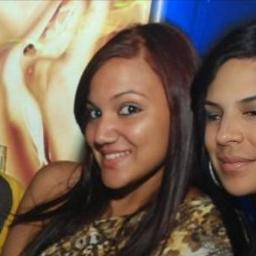

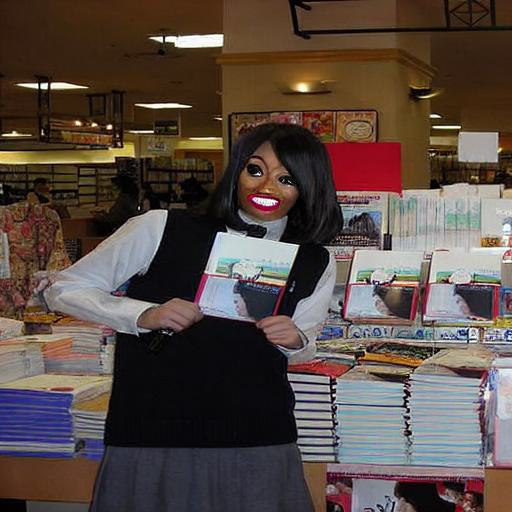

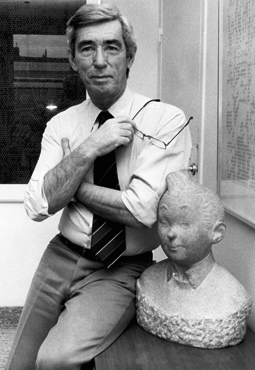

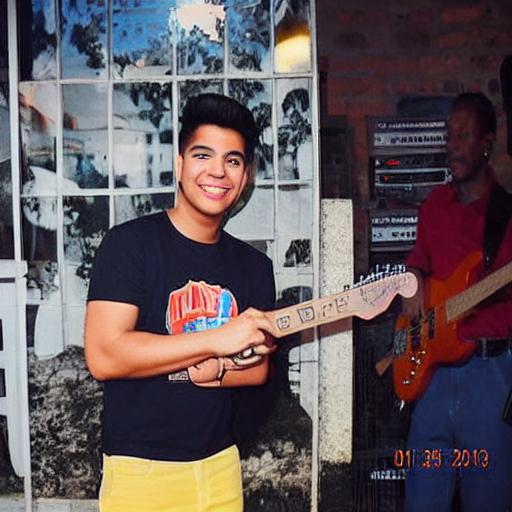

In [36]:
preview_num = 3
sample_images_1 = image_dt_1['train'][0:preview_num]
sample_images_2 = image_dt_2['train'][0:preview_num]
sample_images_3 = image_dt_3['train'][0:preview_num]
sample_images_4 = image_dt_4['train'][0:preview_num]

## Preview Images
for i in range(preview_num):
    display(sample_images_1['image'][i]) 
for i in range(preview_num):
    display(sample_images_2['image'][i])
for i in range(preview_num):
    display(sample_images_3['image'][i])
for i in range(preview_num):
    display(sample_images_4['image'][i])

Testing model quantization across 2 deepfake classifcation models

In [39]:
%%capture
# m1 = pipeline("image-classification", model="prithivMLmods/Deep-Fake-Detector-Model", device='cuda', use_fast=True);  
# m1_32 = pipeline("image-classification", model="prithivMLmods/Deep-Fake-Detector-Model", device='cuda', use_fast=True, torch_dtype='torch.float32'); 
# m1_64 = pipeline("image-classification", model="prithivMLmods/Deep-Fake-Detector-Model", use_fast=True, torch_dtype=torch.float64); 
# m2 = pipeline("image-classification", model="joyc360/deepfakes", device='cuda', use_fast=True)
# m2_16 = pipeline("image-classification", model="joyc360/deepfakes", device='cuda', use_fast=True, torch_dtype=torch.float16)
# m2_32 = pipeline("image-classification", model="joyc360/deepfakes", device='cuda', use_fast=True, torch_dtype=torch.float32)
# m2_64 = pipeline("image-classification", model="joyc360/deepfakes", device='cuda', use_fast=True, torch_dtype=torch.float64) dima806/deepfake_vs_real_image_detection
# m3 = pipeline("image-classification", model="dima806/deepfake_vs_real_image_detection", device='cuda', use_fast=True)
# m3_16 = pipeline("image-classification", model="dima806/deepfake_vs_real_image_detection", device='cuda', use_fast=True, torch_dtype=torch.float16)
# m3_32 = pipeline("image-classification", model="dima806/deepfake_vs_real_image_detection", device='cuda', use_fast=True, torch_dtype=torch.float32)
# m3_64 = pipeline("image-classification", model="dima806/deepfake_vs_real_image_detection", device='cuda', use_fast=True, torch_dtype=torch.float64)

m1 = pipeline("image-classification", model="prithivMLmods/Deep-Fake-Detector-Model", use_fast=True); 
# deepfake_detection16 = pipeline("image-classification", model="prithivMLmods/Deep-Fake-Detector-Model", use_fast=True, torch_dtype=torch.float16);  # inference time explodes
m1_32 = pipeline("image-classification", model="prithivMLmods/Deep-Fake-Detector-Model", use_fast=True, torch_dtype=torch.float32); # torch_dtype='auto' selects float32
m1_64 = pipeline("image-classification", model="prithivMLmods/Deep-Fake-Detector-Model", use_fast=True, torch_dtype=torch.float64); 
### model 2 is not loading propery
m2 = pipeline("image-classification", model="joyc360/deepfakes", use_fast=True) # dima806/deepfake_vs_real_image_detection
#m2_16 = pipeline("image-classification", model="joyc360/deepfakes", use_fast=True, torch_dtype=torch.float16)
m2_32 = pipeline("image-classification", model="joyc360/deepfakes", use_fast=True, torch_dtype=torch.float32)
m2_64 = pipeline("image-classification", model="joyc360/deepfakes", use_fast=True, torch_dtype=torch.float64)
m3 = pipeline("image-classification", model="dima806/deepfake_vs_real_image_detection", use_fast=True)
m3_16 = pipeline("image-classification", model="dima806/deepfake_vs_real_image_detection", use_fast=True, torch_dtype=torch.float16)
m3_32 = pipeline("image-classification", model="dima806/deepfake_vs_real_image_detection", use_fast=True, torch_dtype=torch.float32)
m3_64 = pipeline("image-classification", model="dima806/deepfake_vs_real_image_detection", use_fast=True, torch_dtype=torch.float64)


Device set to use cpu
Device set to use cpu
Device set to use cpu
Invalid model-index. Not loading eval results into CardData.
Device set to use cpu
Invalid model-index. Not loading eval results into CardData.
Device set to use cpu
Invalid model-index. Not loading eval results into CardData.
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu


Inference by model

In [ ]:
num_test = 100 # To have the same training size per dataset, max is 3264 (dataset 2 only has 3264 images for training)
model_list = [m1, m1_32, m1_64, m2, m2_32, m2_64, m3, m3_16, m3_32, m3_64] 
dt_list = [image_dt_1, image_dt_2, image_dt_3, image_dt_4]

# initialize results tables
results_1 = {}
results_2 = {}
results_3 = {}
results_4 = {}
res_dt_pairs = [[image_dt_1, results_1], [image_dt_2, results_2], [image_dt_3, results_3], [image_dt_4, results_4]]

# Train these per dataset

results = {}
run_times = [math.inf] * len(model_list)

for pair in res_dt_pairs:
    #print(pair)
    for i, model in enumerate(model_list, start=1):
        results_df = f'raw_model_{i}'
        
        start = time.time()
        pair[1][results_df] = model(pair[0]['train'][0:num_test]['image']);  
        end = round(time.time() - start, 2)
        
        run_times[i-1] = end

Inference time per model

In [12]:
for i in range(len(results.keys())):
    print('Inference Time for', list(results.keys())[i], ':', run_times[i])

Inference Time for raw_model_1 : 29.74
Inference Time for raw_model_2 : 26.3
Inference Time for raw_model_3 : 62.91
Inference Time for raw_model_4 : 29.21
Inference Time for raw_model_5 : 28.55
Inference Time for raw_model_6 : 64.55


Fn to Convert model output to Pandas DataFrame

In [13]:
res_table = results_table(results)

ROC curves for model results

Result for model_1_res
Result for model_2_res
Result for model_3_res
Result for model_4_res
Result for model_5_res
Result for model_6_res


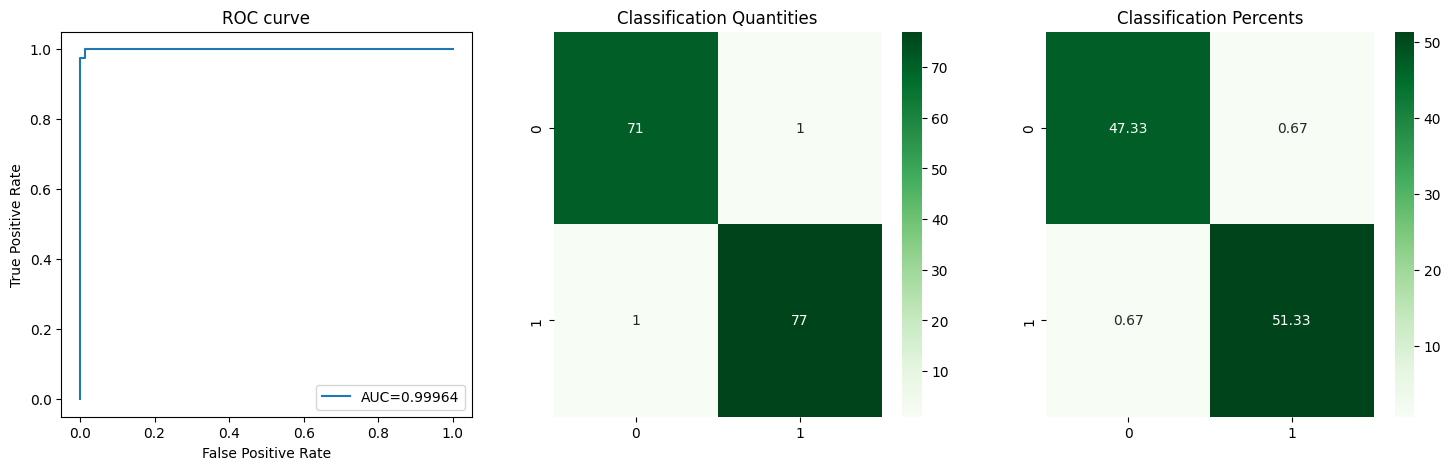

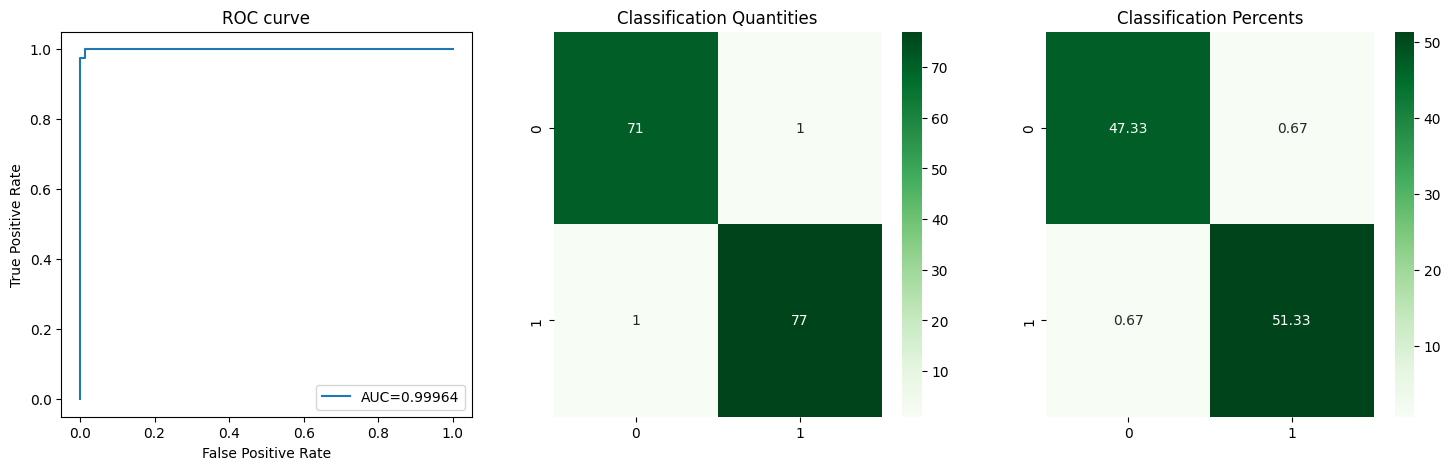

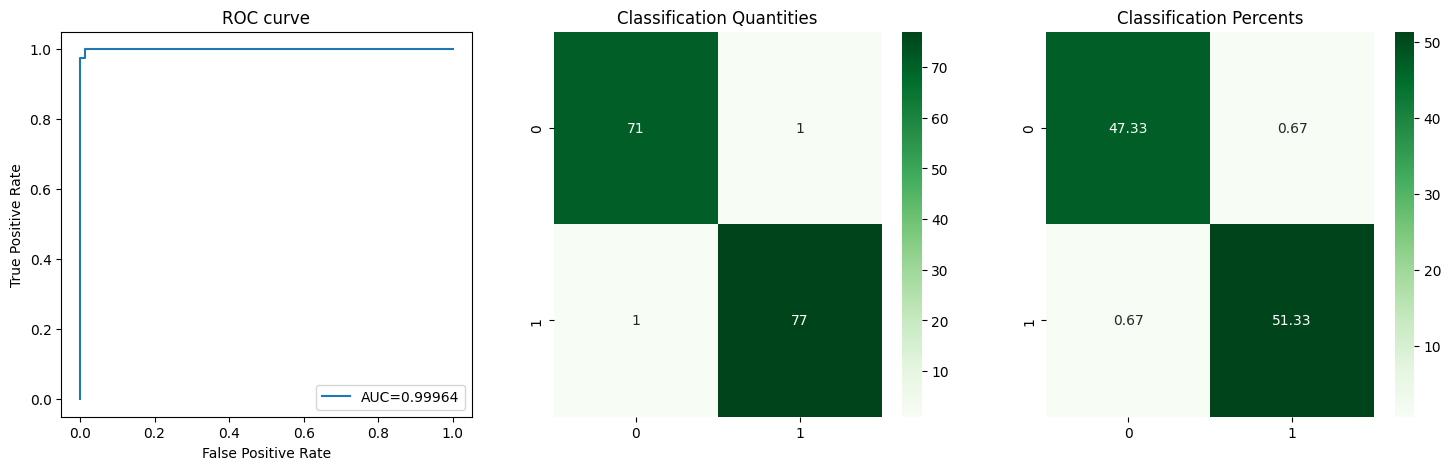

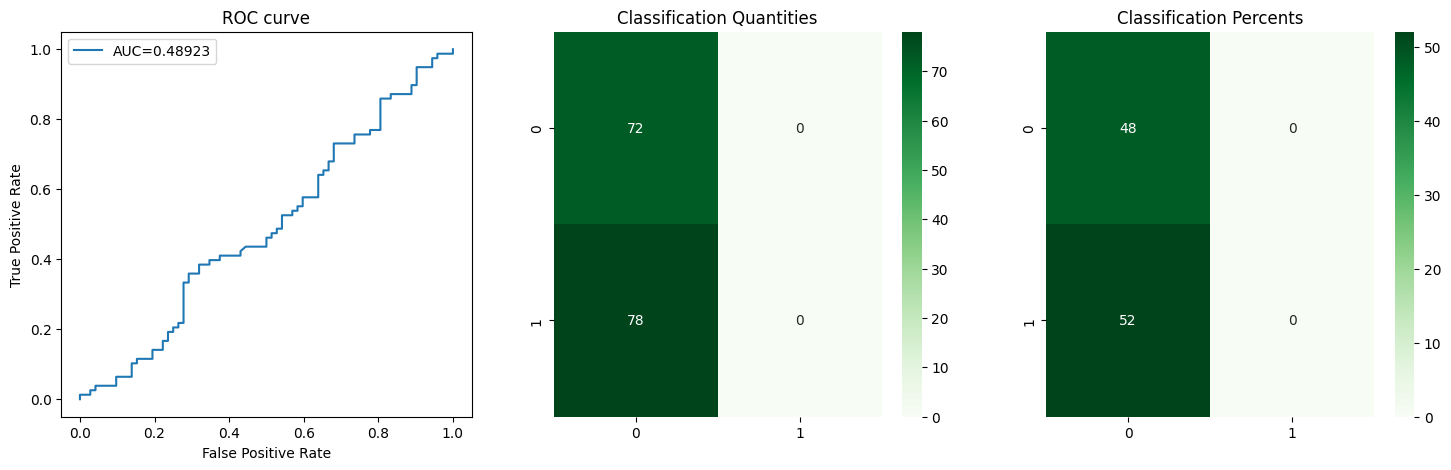

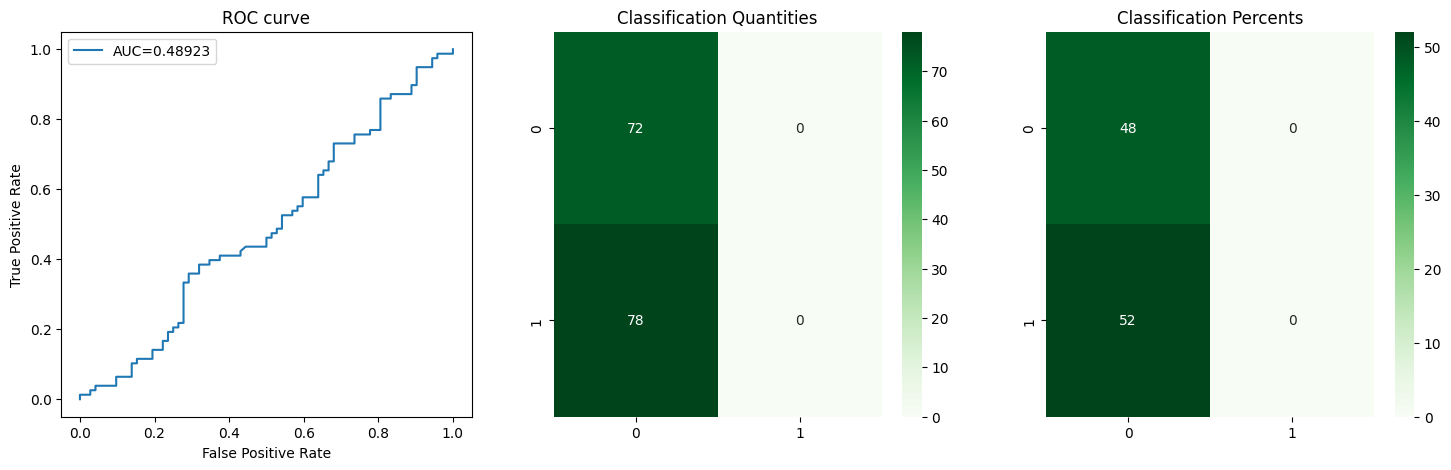

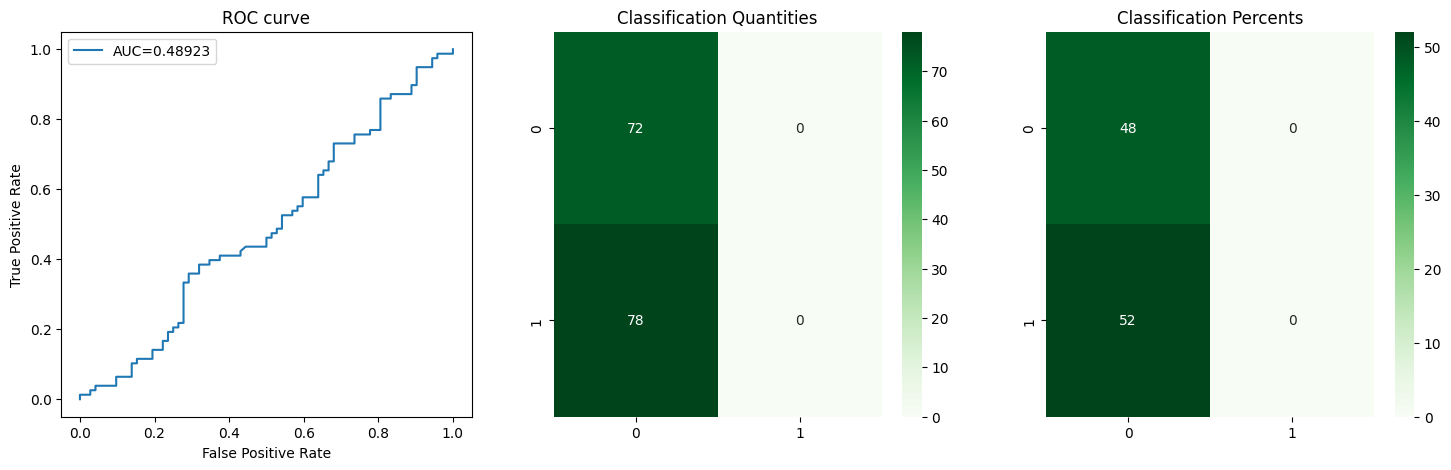

In [14]:
for tbl in res_table.keys():
    print('Result for', tbl)
    res_graphs(res_table[tbl])

In [ ]:
###  code to infer several pipelines

# import time
# #models = ["prithivMLmods/Deep-Fake-Detector-Model", "joyc360/deepfakes"]
# deepfake_detection_1 = pipeline("image-classification", model="prithivMLmods/Deep-Fake-Detector-Model", device='cuda', use_fast=True)
# deepfake_detection_2 = pipeline("image-classification", model="joyc360/deepfakes", device='cuda', use_fast=True)

# start = time.time()
# res_dd1 = deepfake_detection_1(image_dt['train'][0:num_test]['image'])
# end1 = time.time() - start
# print('dd1 completed in:', end1)
# res_dd2 = deepfake_detection_2(image_dt['train'][0:num_test]['image'])
# end2 = time.time() - end1
# print('dd2 completed in:', end2)

In [ ]:
### Future steps
# Prepare batching experiment for runpod
    # test model quantization
    # consider not doing whole dataset and instead focusing on model performance
# Automate Performance stats and result for multiple models
    # functions for the following:
    #   * prepare dataframe with necessary variables
    #   * to create confusion matricies
    #   * create docker image for pod
            # Other way to ensure pod is quickly available for analysis?
# Consider additional datasets

In [ ]:
# On Runpod GPU (1 x RTX 4000 Ada) --- memory constrains when inferring > 20,000 images
    # batching?
# 20,000 images in 160 seconds
# all images (179430) in x time